## Check output of TF process
Quick plots of what the process has produced, so we can see if there are maor problems that need addressing.

31 Jul 2025 | EHU
- 1 Aug: check the additive QDM example.  Looks okay; a bit better than the multiplicative example, as expected.
- 25 Sept: check updated extrapolation examples w/ QDM, mean correction, and CESM/EN4 uncorrected.  Test cftime conversion on CESM raw data.

In [1]:
import os
import sys
import copy
import csv
import time
import datetime
import math
# import dask
import nc_time_axis ## would need this for CESM raw if we didn't modify time axis manually
import cartopy.crs as ccrs ## map projections
import pandas as pd
import numpy as np
import xarray as xr
import netCDF4 as nc
import matplotlib.pyplot as plt

In [10]:
DirIn = f'/Users/eultee/Desktop'

# f_hist = DirIn + 'TF_aQDM-ISMIP_Grid-CESM2-WACCM-1850_2014-PFromStep1-20250731.nc'
# f_fut = DirIn + 'TF_aQDM-ISMIP_Grid-CESM2-WACCM-1985_2101-PFromStep1-20250731.nc'

f_qdm = f'{DirIn}/TF_aQDM-ISMIP_Grid-CESM2-WACCM-1850_2100-PFromStep1-20250924.nc'
f_mc = f'{DirIn}/TF_MeanCorrected-ISMIP_Grid-CESM2-WACCM-1850_2100-PFromStep1-20250924.nc'
f_cesmraw = f'{DirIn}/TF-ISMIP_Grid-CESM2_WACCM_raw-2015_2100-PFromStep1-20250924.nc'
f_en4raw = f'{DirIn}/TF-ISMIP_Grid-EN4-1950_2020-PFromStep1-20250924.nc'

In [11]:
ds_qdm = xr.open_dataset(f_qdm)
ds_qdm

<xarray.Dataset> Size: 58GB
Dimensions:  (time: 3001, y: 2881, x: 1681)
Coordinates:
  * time     (time) datetime64[ns] 24kB 1850-12-31 1851-01-31 ... 2100-12-31
  * y        (y) float32 12kB -3.45e+06 -3.449e+06 ... -5.71e+05 -5.7e+05
  * x        (x) float32 7kB -7.2e+05 -7.19e+05 -7.18e+05 ... 9.59e+05 9.6e+05
Data variables:
    TF       (time, y, x) float32 58GB ...
Attributes:
    title:          QDM-corrected ocean thermal forcing for CESM2-WACCM
    summary:        TF computed following Verjans bias correction and Slater ...
    institution:    NASA Goddard Space Flight Center
    creation_date:  2025-09-24 10:43:19

In [12]:
ds_mc = xr.open_dataset(f_mc)
## somehow saved without coords, so need to intervene
new_time_dim = pd.date_range(start="1850-01-31", end='2100-12-31', freq='ME')
new_x_dim = ds_qdm.x.values ## take it from QDM, same grid
new_y_dim = ds_qdm.y.values
ds_mc = ds_mc.assign_coords(new_time = ('time', new_time_dim), 
                            new_x = ('x', new_x_dim),
                            new_y = ('y', new_y_dim))
# # ds_mc = ds_mc.drop_indexes('time')
ds_mc = ds_mc.set_xindex('new_time')#.drop_vars('time')
ds_mc = ds_mc.set_xindex('new_y')
ds_mc = ds_mc.set_xindex('new_x')
ds_mc = ds_mc.rename({'new_time': 'time',
                     'new_y': 'y',
                     'new_x': 'x'})

ds_mc

/var/folders/lm/d_79zh011jddr2c41jsw0dvr0000gq/T/ipykernel_33724/2732444687.py:13: UserWarning: rename 'new_time' to 'time' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  ds_mc = ds_mc.rename({'new_time': 'time',
/var/folders/lm/d_79zh011jddr2c41jsw0dvr0000gq/T/ipykernel_33724/2732444687.py:13: UserWarning: rename 'new_y' to 'y' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  ds_mc = ds_mc.rename({'new_time': 'time',
/var/folders/lm/d_79zh011jddr2c41jsw0dvr0000gq/T/ipykernel_33724/2732444687.py:13: UserWarning: rename 'new_x' to 'x' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  ds_mc = ds_mc.rename({'new_time': 'time',


<xarray.Dataset> Size: 58GB
Dimensions:  (time: 3012, y: 2881, x: 1681)
Coordinates:
  * time     (time) datetime64[ns] 24kB 1850-01-31 1850-02-28 ... 2100-12-31
  * x        (x) float32 7kB -7.2e+05 -7.19e+05 -7.18e+05 ... 9.59e+05 9.6e+05
  * y        (y) float32 12kB -3.45e+06 -3.449e+06 ... -5.71e+05 -5.7e+05
Data variables:
    TF       (time, y, x) float32 58GB ...
Attributes:
    title:          QDM-corrected ocean thermal forcing for CESM2-WACCM
    summary:        TF computed following Verjans bias correction and Slater ...
    institution:    NASA Goddard Space Flight Center
    creation_date:  2025-09-24 13:17:36

In [13]:
ds_mc_cf = ds_mc.convert_calendar('noleap')
ds_mc_cf

<xarray.Dataset> Size: 57GB
Dimensions:  (time: 2951, y: 2881, x: 1681)
Coordinates:
  * time     (time) object 24kB 1850-01-31 00:00:00 ... 2100-12-31 00:00:00
  * x        (x) float32 7kB -7.2e+05 -7.19e+05 -7.18e+05 ... 9.59e+05 9.6e+05
  * y        (y) float32 12kB -3.45e+06 -3.449e+06 ... -5.71e+05 -5.7e+05
Data variables:
    TF       (time, y, x) float32 57GB ...
Attributes:
    title:          QDM-corrected ocean thermal forcing for CESM2-WACCM
    summary:        TF computed following Verjans bias correction and Slater ...
    institution:    NASA Goddard Space Flight Center
    creation_date:  2025-09-24 13:17:36

In [14]:
fpattern_cesm = f'{DirIn}/TF-ISMIP_Grid-CESM2_WACCM_raw-*-PFromStep1-20250924.nc'
ds_cesm = xr.open_mfdataset(fpattern_cesm)

# ## has cftime.DatetimeNoLeap type, which impedes plotting
# new_time_cesm = pd.date_range(start="1850-01-15", end='2100-12-31', freq='ME')
# ds_cesm = ds_cesm.assign_coords(new_time = ('time', new_time_cesm))
# ds_cesm = ds_cesm.drop_indexes('time')
# ds_cesm = ds_cesm.set_xindex('new_time').drop_vars('time')
# ds_cesm = ds_cesm.rename({'new_time': 'time'})
ds_cesm

<xarray.Dataset> Size: 58GB
Dimensions:  (time: 3012, y: 2881, x: 1681)
Coordinates:
  * time     (time) object 24kB 1850-01-15 13:00:00.000008 ... 2100-12-15 12:...
  * y        (y) float32 12kB -3.45e+06 -3.449e+06 ... -5.71e+05 -5.7e+05
  * x        (x) float32 7kB -7.2e+05 -7.19e+05 -7.18e+05 ... 9.59e+05 9.6e+05
Data variables:
    TF       (time, y, x) float32 58GB dask.array<chunksize=(142, 206, 121), meta=np.ndarray>
Attributes:
    title:          Ocean thermal forcing for CESM2_WACCM_raw
    summary:        TF computed following Verjans bias correction and Slater ...
    institution:    NASA Goddard Space Flight Center
    creation_date:  2025-09-24 15:30:19

In [15]:
ds_en4 = xr.open_dataset(f_en4raw)
ds_en4

<xarray.Dataset> Size: 17GB
Dimensions:  (time: 852, y: 2881, x: 1681)
Coordinates:
  * time     (time) datetime64[ns] 7kB 1950-01-16T12:00:00 ... 2020-12-16T12:...
  * y        (y) float32 12kB -3.45e+06 -3.449e+06 ... -5.71e+05 -5.7e+05
  * x        (x) float32 7kB -7.2e+05 -7.19e+05 -7.18e+05 ... 9.59e+05 9.6e+05
Data variables:
    TF       (time, y, x) float32 17GB ...
Attributes:
    title:          Ocean thermal forcing for EN4
    summary:        TF computed following Verjans bias correction and Slater ...
    institution:    NASA Goddard Space Flight Center
    creation_date:  2025-09-24 14:48:52

Pre-select some sites to examine:

In [16]:
## Donald's choices of Helheim, SK, 79N -- closer to fronts
## be consistent if you're going to use both sections
lats = [66.351326, 69.183958, 79.510158, 81.749738]
lons = [-38.030126, -49.956910, -21.353312, -32.296636]
x3413 = [315179.04921979876, -196927.24454572407, 457005.4899646204, 196860.62799999278]
y3413 = [-2578133.3746258547, -2270554.7538718428, -1043725.1483034123, -873300.4190171139]
site_names = ['Helheim', 'Sermeq Kujalleq', '79N', 'Academy']

---
### Check overlaps
Run this section if you have multiple files covering a common period and you want to check that their values in the overlapping period are close.

In [ ]:
# TF_hist_check = ds_hist.TF.sel(time=slice('1986', '2013'))
# TF_fut_check = ds_fut.TF.sel(time=slice('1986', '2013'))

In [ ]:
# xr.testing.assert_allclose(TF_fut_check, TF_hist_check, rtol=0.1)

This test checks overlaps in the dataset to ensure their values are close to each other.  In test 31 July, we found that some values are not within 10% of each other, but it's not clear which.  Possible these are edge effects, outliers, etc.  

Let's look at a map view:

In [ ]:
fig, axs = plt.subplots(1,3, sharex=True, sharey=True, figsize = (12,4))
TF_hist_check.sel(time='2000', method='nearest').plot(ax=axs[0], vmin=0., vmax=20.)
axs[0].set(title='TF at year 2000, hist. set')
TF_fut_check.sel(time='2000', method='nearest').plot(ax=axs[1], vmin=0., vmax=20.)
axs[1].set(title='TF at year 2000, ssp5-85 set')
(TF_fut_check.sel(time='2000', method='nearest')-TF_hist_check.sel(time='2000', method='nearest')).plot(ax=axs[2])
axs[2].set(title='Difference ssp585-hist')

Now extract some time series:

In [ ]:
## select sites to plot, in latlon coords (deg N, deg E)
# example_sites = {'Sermilik': (65.5, 0.5),
#                  'SK': (69.0, -56.0),
#                  '79N': (82.5, -18)
#                 }

# verts = [(65.5, 0.5),
#          (69.0, -56.0),
#          (82.5, -18)
# ]
# verts= np.asarray(verts)

# import cartopy.crs as ccrs
# proj_ismip = ccrs.epsg(3413)
# proj_latlon = ccrs.PlateCarree()

# transformed_sites = proj_ismip.transform_points(proj_latlon, verts[:,1], verts[:,0])
# transformed_sites

In [ ]:
transformed_sites[0][0]

In [ ]:
# which_site = 2
# coords_to_select = transformed_sites[which_site]

# fig, ax = plt.subplots()
# TF_hist_check.sel(x=coords_to_select[0], y=coords_to_select[1], method='nearest').plot(ax=ax, label='hist')
# TF_fut_check.sel(x=coords_to_select[0], y=coords_to_select[1], method='nearest').plot(ax=ax, label='fut')
# ax.legend()
# ax.set(title='Example site {}'.format(which_site))

Check full length time series for these spots:

In [ ]:
# which_site = 2
# coords_to_select = transformed_sites[which_site]

fig, axs = plt.subplots(1,2, sharex=True, sharey=True)
for i in range(2):
    ax=axs[i]
    which_site = i+1 ## skip site 0
    coords_to_select = transformed_sites[which_site]
    ds_hist.TF.sel(x=coords_to_select[0], y=coords_to_select[1], method='nearest').plot(ax=ax, label='hist')
    ds_fut.TF.sel(x=coords_to_select[0], y=coords_to_select[1], method='nearest').plot(ax=ax, label='fut')
    ax.set(title='Example site {}'.format(which_site))
axs[1].legend()

---
### Extract time series
Run this section to compare different methods at sites near large outlets.

In [ ]:
# 

In [20]:
# Convert CFTimeIndex to DatetimeIndex
datetime_index = ds_cesm.indexes['time'].to_datetimeindex()
cesm_toplot = ds_cesm
cesm_toplot['time'] = datetime_index

/var/folders/lm/d_79zh011jddr2c41jsw0dvr0000gq/T/ipykernel_33724/2420076152.py:2: FutureWarning: In a future version of xarray to_datetimeindex will default to returning a 'us'-resolution DatetimeIndex instead of a 'ns'-resolution DatetimeIndex. This warning can be silenced by explicitly passing the `time_unit` keyword argument.
  datetime_index = ds_cesm.indexes['time'].to_datetimeindex()
/var/folders/lm/d_79zh011jddr2c41jsw0dvr0000gq/T/ipykernel_33724/2420076152.py:2: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  datetime_index = ds_cesm.indexes['time'].to_datetimeindex()


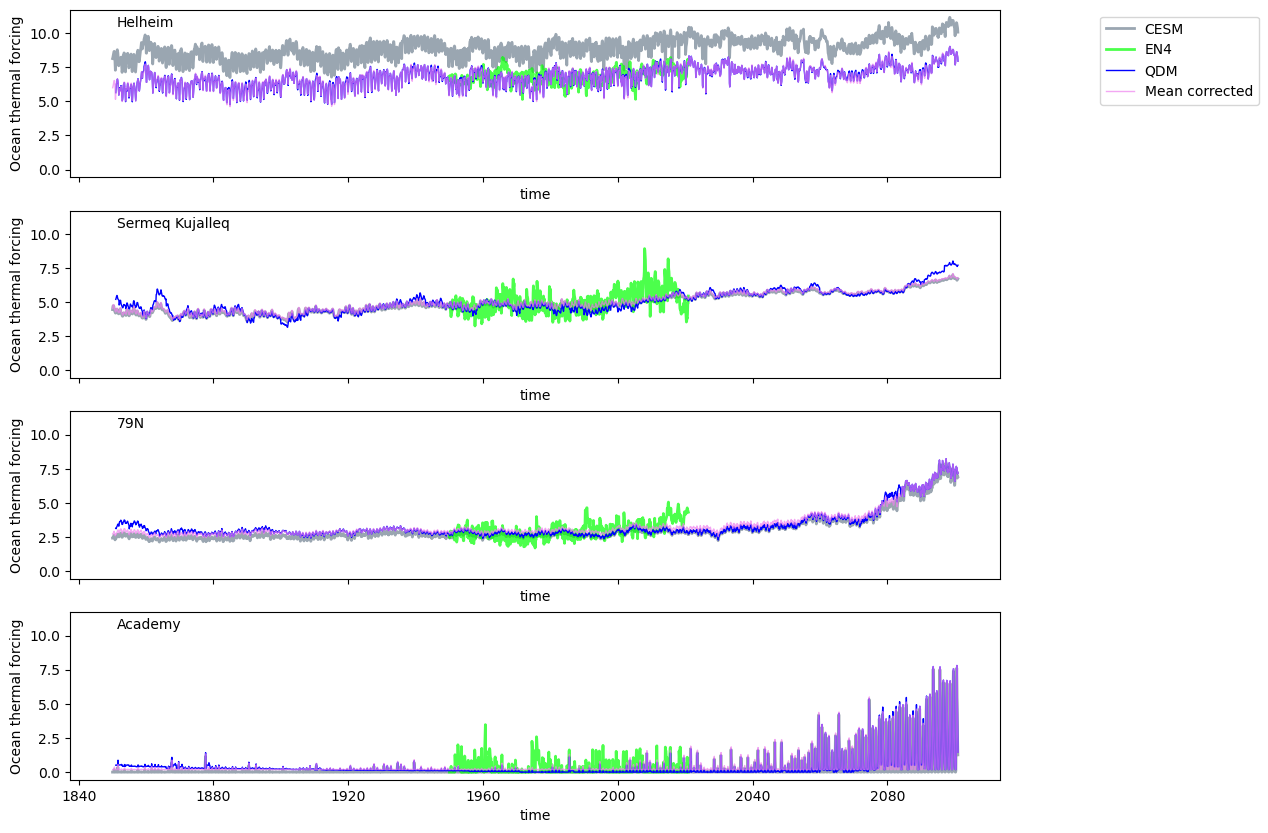

In [23]:
fig, axs = plt.subplots(4,1, figsize=(12,10), sharex=True, sharey=True)
for i in range(4):
    ax=axs[i]
    which_site = site_names[i]
    cesm_toplot.TF.sel(x=x3413[i], y=y3413[i], method='nearest').plot(ax=ax, label='CESM',
                                                                color='slategrey',
                                                                lw=2, ls='-',
                                                               alpha=0.7)
    ds_en4.TF.sel(x=x3413[i], y=y3413[i], method='nearest').plot(ax=ax, label='EN4',
                                                                color='lime',
                                                                lw=2, ls='-',
                                                               alpha=0.7)
    ds_qdm.TF.sel(x=x3413[i], y=y3413[i], method='nearest').plot(ax=ax, label='QDM',
                                                                color='blue',
                                                                lw=1, ls='-')
    ds_mc.TF.sel(x=x3413[i], y=y3413[i], method='nearest').plot(ax=ax, label='Mean corrected',
                                                                color='violet',
                                                                lw=1, ls='-',
                                                               alpha=0.7)

    ## CESM needs nc-time-axis to plot, and mean corrected has corrupted metadata
    ## re-process and return to this
    ax.text(0.05, 0.9, '{}'.format(which_site), transform = ax.transAxes)
    ax.set(title='')
axs[0].legend(bbox_to_anchor=(1.1,1.0));

/Users/eultee/miniforge3/envs/odata/lib/python3.13/site-packages/xarray/groupers.py:498: FutureWarning: 'A' is deprecated and will be removed in a future version, please use 'YE' instead.
  self.index_grouper = pd.Grouper(
/Users/eultee/miniforge3/envs/odata/lib/python3.13/site-packages/xarray/groupers.py:498: FutureWarning: 'A' is deprecated and will be removed in a future version, please use 'YE' instead.
  self.index_grouper = pd.Grouper(
/Users/eultee/miniforge3/envs/odata/lib/python3.13/site-packages/xarray/groupers.py:498: FutureWarning: 'A' is deprecated and will be removed in a future version, please use 'YE' instead.
  self.index_grouper = pd.Grouper(


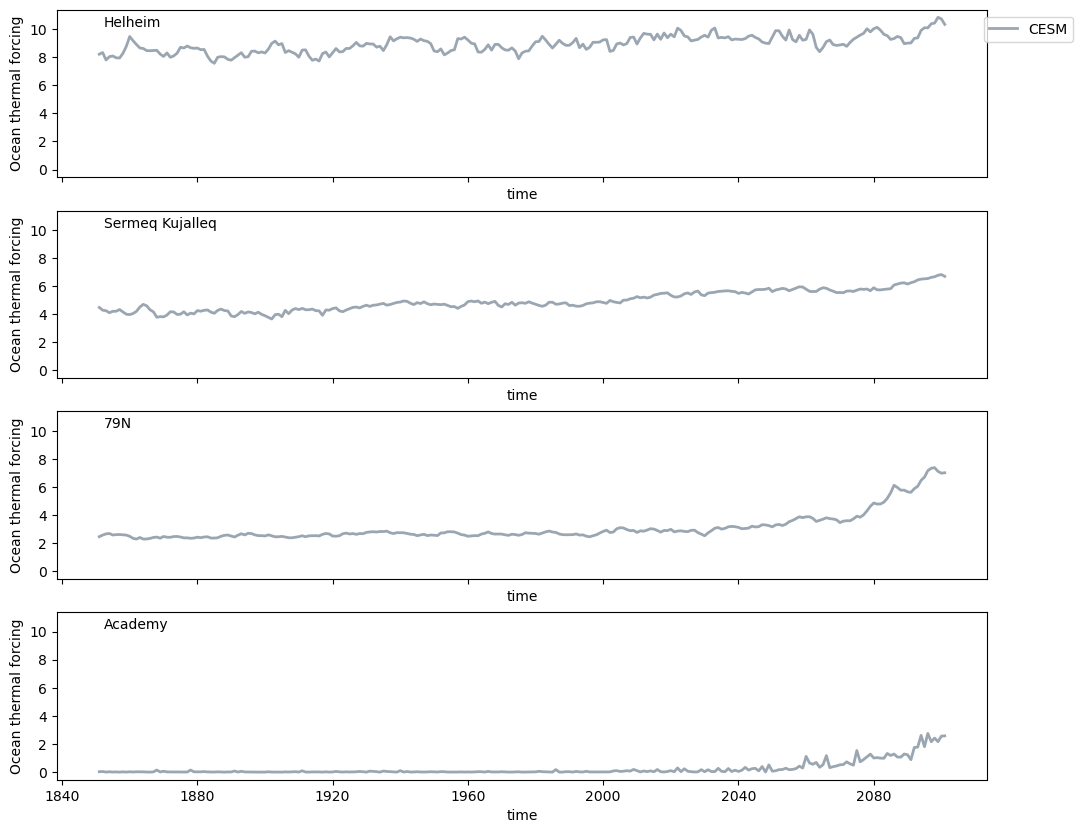

In [26]:
## annual only?

fig, axs = plt.subplots(4,1, figsize=(12,10), sharex=True, sharey=True)
for i in range(4):
    ax=axs[i]
    which_site = site_names[i]
    cesm_toplot.TF.resample(time='A').mean().sel(x=x3413[i], y=y3413[i], method='nearest').plot(ax=ax, label='CESM',
                                                                color='slategrey',
                                                                lw=2, ls='-',
                                                               alpha=0.7)
    # ds_en4.TF.sel(x=x3413[i], y=y3413[i], method='nearest').plot(ax=ax, label='EN4',
    #                                                             color='lime',
    #                                                             lw=2, ls='-',
    #                                                            alpha=0.7)
    # ds_qdm.TF.sel(x=x3413[i], y=y3413[i], method='nearest').plot(ax=ax, label='QDM',
    #                                                             color='blue',
    #                                                             lw=1, ls='-')
    # ds_mc.TF.sel(x=x3413[i], y=y3413[i], method='nearest').plot(ax=ax, label='Mean corrected',
    #                                                             color='violet',
    #                                                             lw=1, ls='-',
    #                                                            alpha=0.7)

    ## CESM needs nc-time-axis to plot, and mean corrected has corrupted metadata
    ## re-process and return to this
    ax.text(0.05, 0.9, '{}'.format(which_site), transform = ax.transAxes)
    ax.set(title='')
axs[0].legend(bbox_to_anchor=(1.1,1.0));